<a href="https://colab.research.google.com/github/saif9402/Dr-Wessam-Project/blob/main/TF_IDF_Feature_Extraction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
from google.colab import files
files.upload()

Saving kaggle.json to kaggle.json


{'kaggle.json': b'{"username":"victornisem","key":"71006e6d61a4419f08a18c42e17cd946"}'}

In [ ]:
!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json

In [ ]:
!kaggle datasets download -d anupampaul005/fake-news-dataset

Dataset URL: https://www.kaggle.com/datasets/anupampaul005/fake-news-dataset
License(s): MIT


In [ ]:
!unzip fake-news-dataset.zip


Archive:  fake-news-dataset.zip
  inflating: dataset.csv             


In [ ]:
import os
print(os.listdir())

['.config', 'kaggle.json', 'dataset.csv', 'fake-news-dataset.zip', 'sample_data']


In [ ]:
import pandas as pd

df = pd.read_csv('dataset.csv')
print(df.head())

                                               title  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  Trump, top defense officials, discuss North Ko...   
2  British civil servants' union calls nationwide...   
3   A**hole Of The Day – Michele Bachmann: Muslim...   
4  ’Deport Fat People’ Posters Appear At CU Bould...   

                                                text  unreliable  \
0  WARNING: A Pivotal Moment For The Stock Market...           1   
1  WASHINGTON  - U.S. President Donald Trump met ...           0   
2  LONDON  - British civil servants will vote nex...           0   
3  Michele Bachmann has been pretty quiet since l...           1   
4  Posters calling on Donald Trump to “Deport Fat...           0   

                            author  
0  Anonymous Coward (UID 72071746)  
1                          Unknown  
2                          Unknown  
3                          Unknown  
4                      Lucas Nolan  


In [ ]:
df['content'] = df['title'].fillna('') + ' ' + df['text'].fillna('')


In [ ]:
df['label'] = df['unreliable']

# Check result
print(df[['title', 'text', 'content', 'label']].head())

                                               title  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  Trump, top defense officials, discuss North Ko...   
2  British civil servants' union calls nationwide...   
3   A**hole Of The Day – Michele Bachmann: Muslim...   
4  ’Deport Fat People’ Posters Appear At CU Bould...   

                                                text  \
0  WARNING: A Pivotal Moment For The Stock Market...   
1  WASHINGTON  - U.S. President Donald Trump met ...   
2  LONDON  - British civil servants will vote nex...   
3  Michele Bachmann has been pretty quiet since l...   
4  Posters calling on Donald Trump to “Deport Fat...   

                                             content  label  
0  WARNING: A Pivotal Moment For The Stock Market...      1  
1  Trump, top defense officials, discuss North Ko...      0  
2  British civil servants' union calls nationwide...      0  
3   A**hole Of The Day – Michele Bachmann: Muslim...      1  
4  ’Deport Fat P

In [ ]:
import re, string, nltk
from nltk.corpus import stopwords
from nltk.stem import WordNetLemmatizer

In [ ]:
nltk.download('stopwords')
nltk.download('wordnet')

stop_words = set(stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

def preprocess(text):
    text = text.lower()
    text = re.sub(f"[{string.punctuation}]", "", text)
    text = re.sub(r'\d+', '', text)
    words = [w for w in text.split() if w not in stop_words]
    words = [lemmatizer.lemmatize(w) for w in words]
    return ' '.join(words)

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Unzipping corpora/stopwords.zip.
[nltk_data] Downloading package wordnet to /root/nltk_data...


In [ ]:
df['cleaned_content'] = df['content'].apply(preprocess)

df = df[df['cleaned_content'].str.split().str.len() > 5]

In [ ]:
# ---------------------- Data Splitting and TF-IDF ----------------------
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import TfidfVectorizer

# Drop rows with missing text or label
df = df.dropna(subset=['text', 'label'])

X = df['text']
y = df['label']

X_train_val, X_test, y_train_val, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=0.25, random_state=42)

tfidf = TfidfVectorizer(max_features=5000)
X_train_tfidf = tfidf.fit_transform(X_train)
X_val_tfidf = tfidf.transform(X_val)
X_test_tfidf = tfidf.transform(X_test)



Logistic Regression Evaluation Metrics:
Training Accuracy: 0.9762595419847329
Testing Accuracy: 0.9564155407984123
Precision: 0.9555817031916458
Recall: 0.9602423884126515
F1 Score: 0.9579063767047549
Confusion Matrix:
 [[6033  302]
 [ 269 6497]]


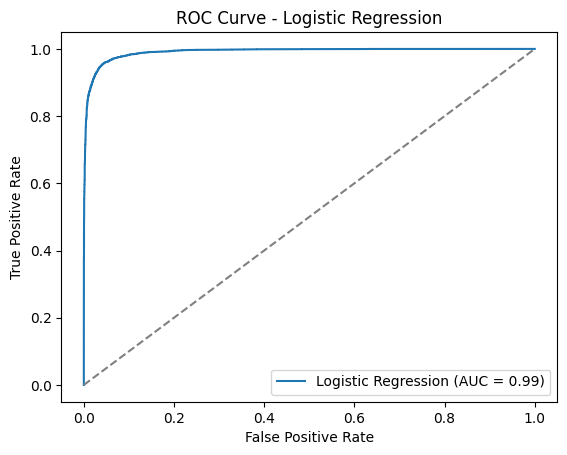

In [ ]:
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

# Train the Logistic Regression model
log_model = LogisticRegression(C=10, class_weight=None, penalty='l2', solver='lbfgs', max_iter=1000)
log_model.fit(X_train_tfidf, y_train)

# Predict probabilities and labels
log_probs = log_model.predict_proba(X_test_tfidf)[:, 1]
log_preds = log_model.predict(X_test_tfidf)
train_preds = log_model.predict(X_train_tfidf)

# Evaluation metrics
print("\nLogistic Regression Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(y_train, train_preds))
print("Testing Accuracy:", accuracy_score(y_test, log_preds))
print("Precision:", precision_score(y_test, log_preds))
print("Recall:", recall_score(y_test, log_preds))
print("F1 Score:", f1_score(y_test, log_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, log_preds))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, log_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Logistic Regression (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Logistic Regression')
plt.legend(loc='lower right')
plt.show()



Random Forest Evaluation Metrics:
Training Accuracy: 0.9999491094147582
Testing Accuracy: 0.9398519197007862
Precision: 0.9308157970596713
Recall: 0.9544782737215489
F1 Score: 0.9424985405720957
Confusion Matrix:
 [[5855  480]
 [ 308 6458]]


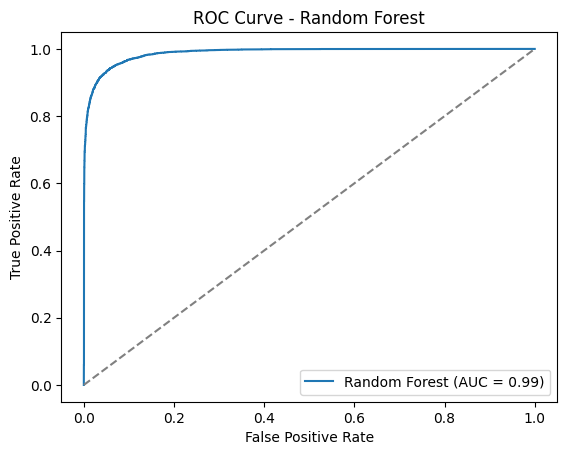

In [ ]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

# Train the Random Forest model
rf_model = RandomForestClassifier(
    n_estimators=300,
    max_depth=50,
    max_features='sqrt',
    min_samples_split=2,
    min_samples_leaf=1,
    class_weight=None,
    random_state=42
)
rf_model.fit(X_train_tfidf, y_train)

# Predict probabilities and labels
rf_probs = rf_model.predict_proba(X_test_tfidf)[:, 1]
rf_preds = rf_model.predict(X_test_tfidf)
rf_train_preds = rf_model.predict(X_train_tfidf)

# Evaluation metrics
print("\nRandom Forest Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(y_train, rf_train_preds))
print("Testing Accuracy:", accuracy_score(y_test, rf_preds))
print("Precision:", precision_score(y_test, rf_preds))
print("Recall:", recall_score(y_test, rf_preds))
print("F1 Score:", f1_score(y_test, rf_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, rf_preds))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, rf_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Random Forest (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Random Forest')
plt.legend(loc='lower right')
plt.show()



Gradient Boosting Evaluation Metrics:
Training Accuracy: 0.9322900763358779
Testing Accuracy: 0.9302343332570033
Precision: 0.9313089622641509
Recall: 0.9337865799586166
F1 Score: 0.9325461254612546
Confusion Matrix:
 [[5869  466]
 [ 448 6318]]


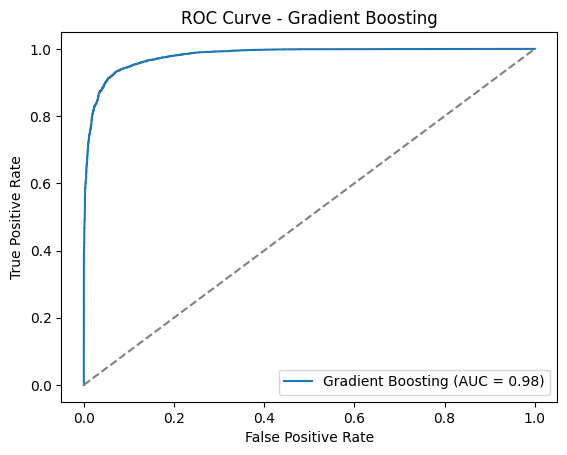

In [ ]:
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.metrics import (
    accuracy_score, precision_score, recall_score, f1_score,
    confusion_matrix, roc_curve, auc
)
import matplotlib.pyplot as plt

# Initialize and train the Gradient Boosting model
gb_model = GradientBoostingClassifier(n_estimators=100, learning_rate=0.1, random_state=42)
gb_model.fit(X_train_tfidf, y_train)

# Predict probabilities and labels
gb_probs = gb_model.predict_proba(X_test_tfidf)[:, 1]
gb_preds = gb_model.predict(X_test_tfidf)
gb_train_preds = gb_model.predict(X_train_tfidf)

# Evaluation Metrics
print("\nGradient Boosting Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(y_train, gb_train_preds))
print("Testing Accuracy:", accuracy_score(y_test, gb_preds))
print("Precision:", precision_score(y_test, gb_preds))
print("Recall:", recall_score(y_test, gb_preds))
print("F1 Score:", f1_score(y_test, gb_preds))
print("Confusion Matrix:\n", confusion_matrix(y_test, gb_preds))

# ROC Curve
fpr, tpr, _ = roc_curve(y_test, gb_probs)
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='Gradient Boosting (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - Gradient Boosting')
plt.legend(loc='lower right')
plt.show()


In [ ]:
!pip install tensorflow


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Epoch 1/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 526s 842ms/step - accuracy: 0.8749 - loss: 0.2976 - val_accuracy: 0.9518 - val_loss: 0.1405
Epoch 2/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 558s 842ms/step - accuracy: 0.9649 - loss: 0.1054 - val_accuracy: 0.9669 - val_loss: 0.1105
Epoch 3/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 559s 837ms/step - accuracy: 0.9764 - loss: 0.0730 - val_accuracy: 0.9581 - val_loss: 0.1223
Epoch 4/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 544s 809ms/step - accuracy: 0.9843 - loss: 0.0481 - val_accuracy: 0.9608 - val_loss: 0.1242
Epoch 5/10
615/615 ━━━━━━━━━━━━━━━━━━━━ 505s 821ms/step - accuracy: 0.9904 - loss: 0.0303 - val_accuracy: 0.9573 - val_loss: 0.1462
410/410 ━━━━━━━━━━━━━━━━━━━━ 54s 131ms/step
1229/1229 ━━━━━━━━━━━━━━━━━━━━ 162s 132ms/step

LSTM Evaluation Metrics:
Training Accuracy: 0.9967684478371501
Testing Accuracy: 0.9570261812075415
Precision: 0.963671699805651
Recall: 0.9527046999704404
F1 Score: 0.9581568190263843
Confusion Matrix:
 [[6092  243]
 [ 320 6446]]


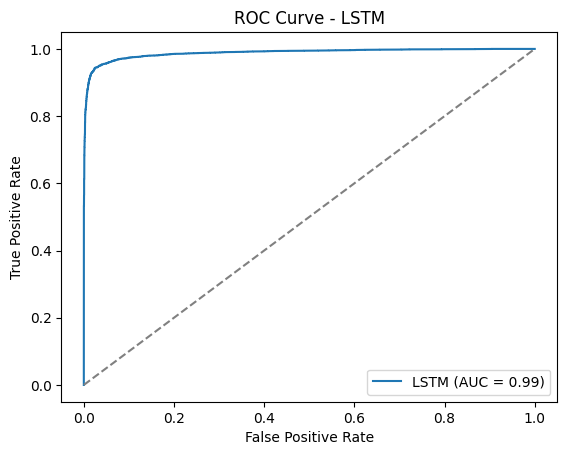

In [ ]:
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical
from sklearn.preprocessing import LabelEncoder
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, SpatialDropout1D
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, confusion_matrix, roc_curve, auc
import matplotlib.pyplot as plt

# Parameters
MAX_NB_WORDS = 50000
MAX_SEQUENCE_LENGTH = 250
EMBEDDING_DIM = 100

# Tokenize and pad sequences
tokenizer = Tokenizer(num_words=MAX_NB_WORDS)
tokenizer.fit_on_texts(X_train)

X_train_seq = tokenizer.texts_to_sequences(X_train)
X_val_seq = tokenizer.texts_to_sequences(X_val)
X_test_seq = tokenizer.texts_to_sequences(X_test)

X_train_pad = pad_sequences(X_train_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_val_pad = pad_sequences(X_val_seq, maxlen=MAX_SEQUENCE_LENGTH)
X_test_pad = pad_sequences(X_test_seq, maxlen=MAX_SEQUENCE_LENGTH)

# Encode labels
le = LabelEncoder()
y_train_enc = to_categorical(le.fit_transform(y_train))
y_val_enc = to_categorical(le.transform(y_val))
y_test_enc = to_categorical(le.transform(y_test))

# Build and compile LSTM model
model = Sequential()
model.add(Embedding(MAX_NB_WORDS, EMBEDDING_DIM, input_length=MAX_SEQUENCE_LENGTH))
model.add(SpatialDropout1D(0.2))
model.add(LSTM(100, dropout=0.2, recurrent_dropout=0.2))
model.add(Dense(2, activation='softmax'))

model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

early_stop = EarlyStopping(monitor='val_loss', patience=3)

# Train model
history = model.fit(X_train_pad, y_train_enc,
                    validation_data=(X_val_pad, y_val_enc),
                    epochs=10, batch_size=64, callbacks=[early_stop])

# Predict and evaluate
y_pred_prob = model.predict(X_test_pad)
y_pred = y_pred_prob.argmax(axis=1)
y_true = y_test_enc.argmax(axis=1)

# Training predictions and accuracy
train_pred_prob = model.predict(X_train_pad)
train_pred = train_pred_prob.argmax(axis=1)
train_true = y_train_enc.argmax(axis=1)

print("\nLSTM Evaluation Metrics:")
print("Training Accuracy:", accuracy_score(train_true, train_pred))
print("Testing Accuracy:", accuracy_score(y_true, y_pred))
print("Precision:", precision_score(y_true, y_pred))
print("Recall:", recall_score(y_true, y_pred))
print("F1 Score:", f1_score(y_true, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))

# ROC Curve
fpr, tpr, _ = roc_curve(y_true, y_pred_prob[:, 1])
roc_auc = auc(fpr, tpr)

plt.figure()
plt.plot(fpr, tpr, label='LSTM (AUC = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], linestyle='--', color='gray')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ROC Curve - LSTM')
plt.legend(loc='lower right')
plt.show()


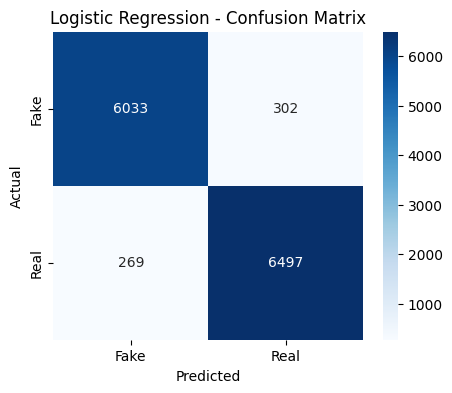

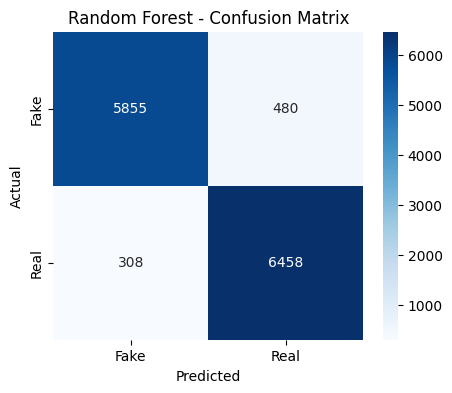

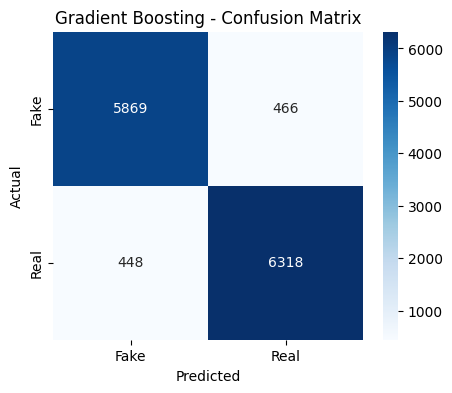

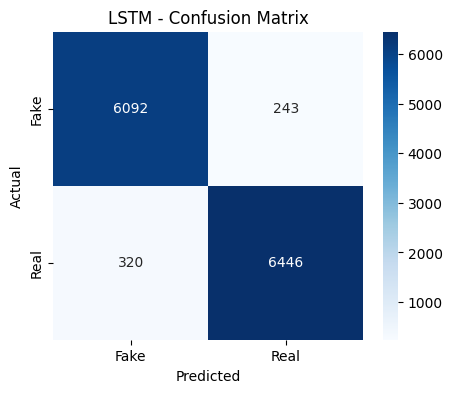

In [ ]:

import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import confusion_matrix

def plot_confusion_matrix(model_name, y_true, y_pred, labels=['Fake', 'Real']):
    cm = confusion_matrix(y_true, y_pred)
    plt.figure(figsize=(5, 4))
    sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted')
    plt.ylabel('Actual')
    plt.title(f'{model_name} - Confusion Matrix')
    plt.show()

# Plot for Logistic Regression
plot_confusion_matrix("Logistic Regression", y_test, log_preds)


# Plot for Random Forest
plot_confusion_matrix("Random Forest", y_test, rf_preds)

# Plot for SVM
plot_confusion_matrix("Gradient Boosting", y_test, gb_preds)

# Plot for LSTM
plot_confusion_matrix("LSTM", y_true, y_pred)  # y_true/y_pred from LSTM
